# Daily activity level of Atlantic cod

Data storage tags (DSTs) are widely used to study the behavior of marine animals. 
In this exercise, we use depth time-series data recorded by the DST attached to Atlantic cod to determine the fish's activity level.
<img src="images/DST_tagged_cod-140.JPG" width="300">

The data were downloaded from the Star-ODDI milli DST using the SeaStar software, and saved to a .mat file using the [preprocessing script](https://github.com/cliu3/hmm_smast/tree/dev/test/preprocessing).

In [1]:
%matplotlib inline
import scipy.io
import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.time import Time

First, we read the raw data, convert the date/time and write into a pandas dataframe.

In [2]:
tag=scipy.io.loadmat('/Users/cliu/Dropbox/Geolocation/projects/cod_zemeckis/tag_data/13_raw.mat',squeeze_me =False,struct_as_record=True)
tag=tag['tag']
dnum=tag['dnum'][0,0][:,0]
temp=tag['temp'][0,0][:,0]
depth=tag['depth'][0,0][:,0]
dnum=dnum-678942
idx=depth>20



data=pd.DataFrame({'dnum':dnum[idx],'temp':temp[idx],'depth':depth[idx]})
data['DATE']=Time(data.dnum,format='mjd',scale='utc').datetime
data['DATE']=pd.to_datetime(data['DATE'])
data = data.set_index('DATE')
data.index = data.index.round('S')

Plotting the raw depth time-series data. The time resolution is 15 minute and the depth resolution is 0.1 m.

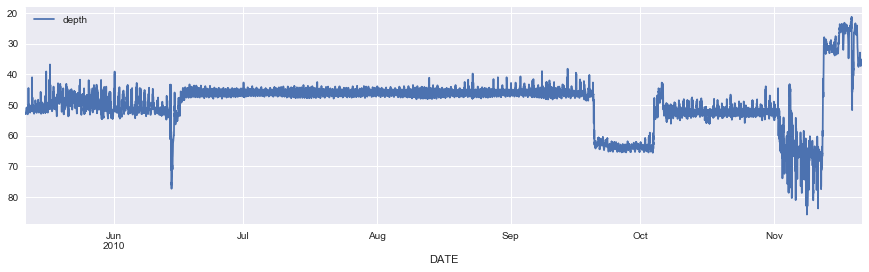

In [3]:
data.plot(y='depth', figsize=(15,4)).invert_yaxis()

Zooming in to a 4-day portion of the data, we can see clear signals of tidal variation.

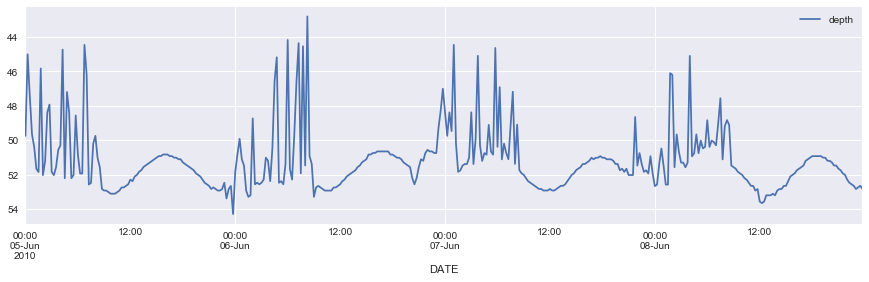

In [4]:
data['2010-Jun-5':'2010-Jun-8'].plot(y='depth', figsize=(15,4)).invert_yaxis()

Alternatively, the raw depth data can also be plotted as a 2-D plot, with date as the x-axis, and time of the day as the y-axis. In this 2-D plot, tidal variations are shown as the tilted bars, and the off-bottom movements (possibly feeding behaviors) are shown as horizontal bars of noises.

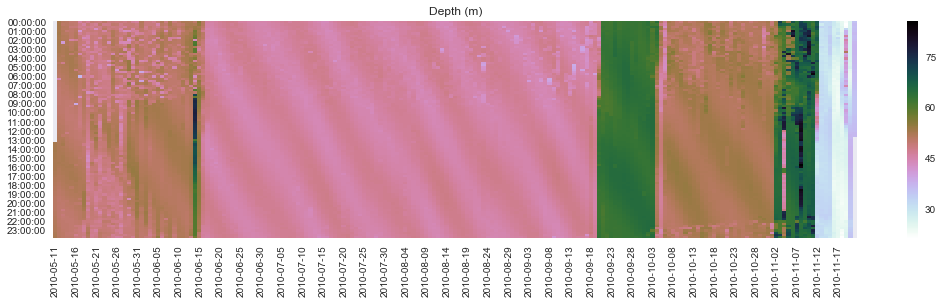

In [5]:
groups = data['depth'].groupby(pd.TimeGrouper('D'))
days = pd.DataFrame()
for name, group in groups:
    ts = pd.DataFrame({str(name.date()):group.values}, index=[val.time() for val in group.index])
    days = pd.concat([days, ts], axis=1)
plt.figure(figsize=(18, 4))
ax = sns.heatmap(days, cmap='cubehelix_r', xticklabels=5, yticklabels=4)
plt.title('Depth (m)')

## Original: The tidal detection method

In the original tidal fitting method, we calculate the least-square fit of the depth signal with a sinusoidal wave. Days are categorized as low activity when there is a satisfactory fit over a 13 h window, moderate activity days are identified as those with satisfactory fits when using a 5 h window, and high activity days are those during which there are no reliable tidal fits. Implementation details of the method can be found [here](https://github.com/cliu3/hmm_smast/blob/dev/datalik/likelihood_cliu.m).
![title](images/tidal_activity.png)

This method works well when the depth sensor resolution is good (0.1 m in this case for the Star-ODDI DSTs). However, many other archival tags have poorer depth sensor resolution, thus this method will not be applicable to data from these tags.

## Alternative: The cumulative daily depth change method

Now we look for an alternative method to classify daily activity level from depth data. From the plot above, it is evident that lots of vertical movements happen during a high activity day, and much fewer happen during a low activity day.

We first compute the changes in depth between consecutive time steps, using `diff()` function:

In [6]:
data['depth_change'] = abs(data['depth'].diff())

To explore the changes in depth we just calculated, we plot it as a 2-D plot and compare it with the color-coded activity levels determined using the tidal detection method (yellow: low, light green: moderate, dark green: high). It is clear that on low activity days there are fewer changes in depth.

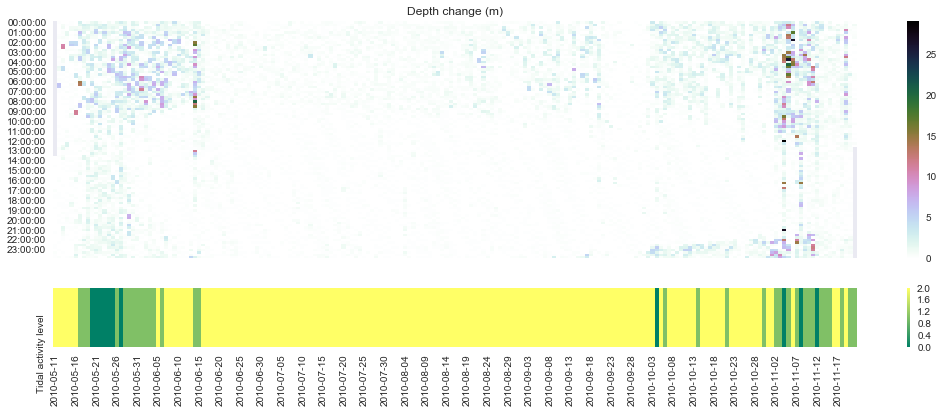

In [7]:
groups = data['depth_change'].groupby(pd.TimeGrouper('D'))
days = pd.DataFrame()
for name, group in groups:
    ts = pd.DataFrame({str(name.date()):group.values}, index=[val.time() for val in group.index])
    days = pd.concat([days, ts], axis=1)
fig = plt.figure(figsize=(18, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax1)
# fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), nrows=2, sharex=True)

sns.heatmap(days, cmap='cubehelix_r', xticklabels=5, yticklabels=4, ax=ax1)
ax1.set_title('Depth change (m)')
plt.setp(ax1.get_xticklabels(), visible=False)

# plot tidal activity level
tagname=str(tag['fish_id'][0,0][0,0])+'_'+tag['tag_id'][0,0][0]
lv=scipy.io.loadmat('/Users/cliu/Dropbox/Geolocation/smast_geolocate/run_dtcod_hpcc_cscvr/ObsLh'+tagname+'.mat',squeeze_me =False,struct_as_record=True)
tide = lv['tide'][0]
df_tide = pd.DataFrame(index=days.columns, data={"Tidal activity level":tide})
sns.heatmap(df_tide.T, cmap='summer', xticklabels=5, ax=ax2)

Next, we compute the cumulative daily depth change, by summing the changes in depth between consecutive time steps for each day:

In [8]:
depth_change_sum = data['depth_change'].resample('D').sum()
depth_change_sum.index = depth_change_sum.index.astype('str')
daily = pd.concat([df_tide, depth_change_sum], axis=1)

Now let's plot the cumulative daily depth change, with color code representing, again, the activity levels determined using the tidal detection method.

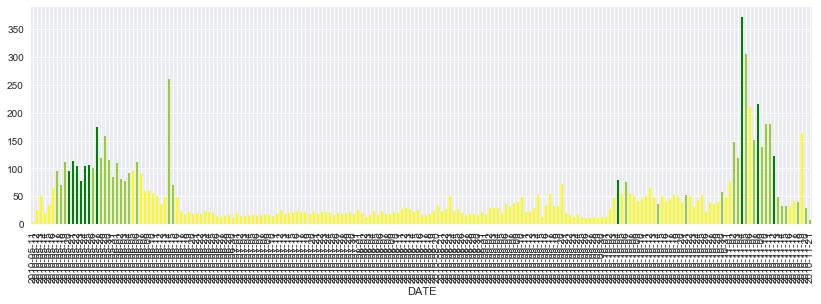

In [9]:
colors = {0: 'green', 1: 'yellowgreen', 2: 'yellow'}
daily['depth_change'].plot(kind='bar', color=[colors[i] for i in daily['Tidal activity level']], figsize=(14,4))

A box plot of the cumulative daily depth change against the activity levels determined using the tidal detection method also confirms a trend of decreased depth change on lower activity days:

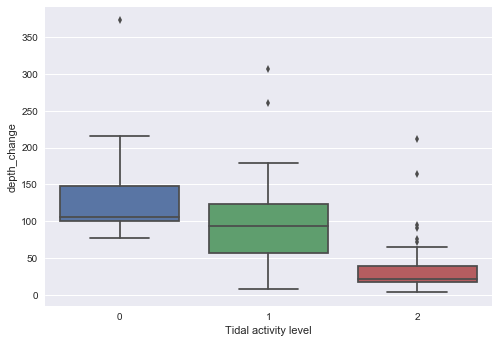

In [10]:
sns.boxplot(x='Tidal activity level', y='depth_change', data=daily)

A histogram shows the distribution of the cumulative daily depth change:

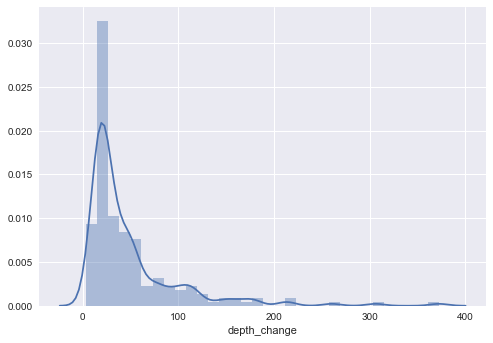

In [11]:
sns.distplot(daily['depth_change'])

Here we use the Jenks natural breaks algorithm to cluster the daily cumulative depth change into three activity levels. These breaks are determined such that the average deviation from the mean is minimized for each group, while each class’s deviation from the means of the other groups is maximized.

In [12]:
import jenkspy
breaks = jenkspy.jenks_breaks(depth_change_sum.values, nb_class=3)

The boundaries determined by the Jenks algorithm are:

In [13]:
breaks

[4.060999999999993, 65.6348, 179.65350000000004, 372.32930000000005]

Bar plot of the daily cumulative depth changes with color coded activity levels determined by the Jenks algorithm:

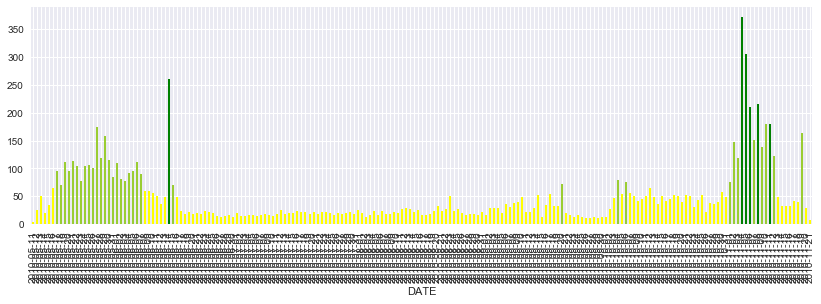

In [14]:
y_pred = np.piecewise(depth_change_sum.values, [depth_change_sum.values<=breaks[1], (depth_change_sum.values>breaks[1]) & (depth_change_sum.values<breaks[2]), depth_change_sum.values>breaks[2]], [2, 1, 0])
colors = {0: 'green', 1: 'yellowgreen', 2: 'yellow'}
depth_change_sum.plot(kind='bar', color=[colors[i] for i in y_pred], figsize=(14,4))

Now we decrease the depth resolution to 0.5 m, to mimic data from a tag with a coarser sensor resolution:

In [15]:
def round_of_rating(number):
    return round(number * 2) / 2

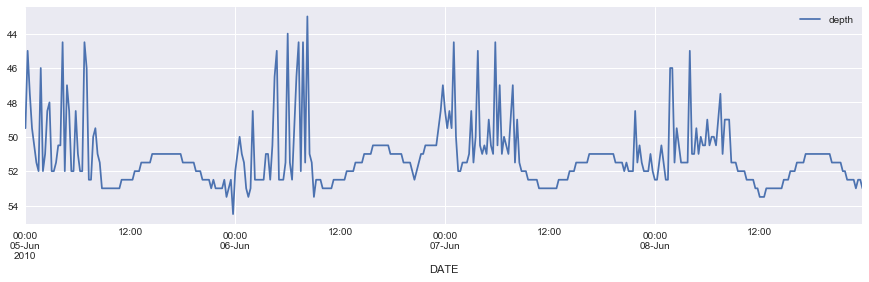

In [16]:
depth = np.array([round_of_rating(i) for i in depth])
data['depth'] = depth
data['2010-Jun-5':'2010-Jun-8'].plot(y='depth', figsize=(15,4)).invert_yaxis()

Perform the same computation for the activity levels:

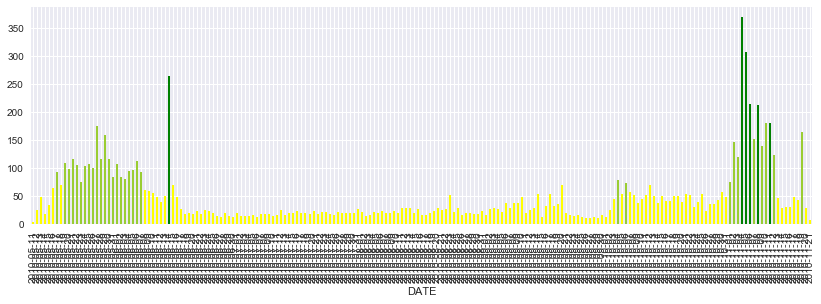

In [17]:
data['depth_change'] = abs(data['depth'].diff())
depth_change_sum = data['depth_change'].resample('D').sum()
depth_change_sum.index = depth_change_sum.index.astype('str')
breaks = jenkspy.jenks_breaks(depth_change_sum.values, nb_class=3)
y_pred_half = np.piecewise(depth_change_sum.values, [depth_change_sum.values<=breaks[1], (depth_change_sum.values>breaks[1]) & (depth_change_sum.values<breaks[2]), depth_change_sum.values>breaks[2]], [2, 1, 0])
colors = {0: 'green', 1: 'yellowgreen', 2: 'yellow'}
depth_change_sum.plot(kind='bar', color=[colors[i] for i in y_pred_half], figsize=(14,4))

In [18]:
sum(y_pred == y_pred_half)/len(y_pred)

0.98461538461538467

Between 0.1 m and 0.5 m resolutions, the cumulative daily depth change method yields very similar results (98.5% of the classifications are the same), indicating that the cumulative daily depth change method is stable and insensitive to tag depth resolutions.